In [53]:
import pandas as pd
pd.set_option('display.max_rows', 200)
proposals = pd.read_parquet("output_data/snapshot/cleaned_proposals.parquet")
# 145 records
# print(proposals.info())
proposals['choices'] = proposals['choices'].apply(lambda x: ', '.join(map(str, x)))

filtered_proposals = proposals[proposals["choices"] == 'For, Against, Abstain']
# 126 records
# filtered_proposals.info()

voting = pd.read_parquet("output_data/snapshot/votes.parquet")

filtered_votes = pd.merge(
    filtered_proposals, voting, left_on="id", right_on="proposal_id", how="inner"
)
# filtered_votes.info()
voting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3756152 entries, 0 to 3756151
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   voter           object 
 2   created         int64  
 3   choice          object 
 4   vp              float64
 5   vp_by_strategy  object 
 6   vp_state        object 
 7   reason          object 
 8   app             object 
 9   proposal_id     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 286.6+ MB


In [54]:
import pandas as pd

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:.2f}'.format)

karma_delegates = pd.read_parquet("output_data/karma/delegates.parquet")
# voting = pd.read_parquet("output_data/snapshot/votes.parquet")
filtered_votes['voter'] = filtered_votes['voter'].str.lower()

voting_merged_df = pd.merge(
    karma_delegates, filtered_votes, left_on="publicAddress", right_on="voter"
)
voting_merged_df = voting_merged_df[['publicAddress', 'choice', 'vp', 'proposal_id']]

# sample
df = voting_merged_df[voting_merged_df['proposal_id'] == "0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b994fef2e24d9a54e4033a"]

# print(df.describe())

# all voters
voting = voting[voting['proposal_id'] == "0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b994fef2e24d9a54e4033a"]
count_by_choice = voting.groupby('choice').size()

# delegates voters
count_by_choice = df.groupby('choice').size()

print(count_by_choice)

choice
1     75
2    100
3     11
dtype: int64


In [55]:
import os

pivoted_df = voting_merged_df.pivot(index='publicAddress', columns='proposal_id', values='choice')
pivoted_df.columns = [f'proposal_{col}_choice' for col in pivoted_df.columns]
pivoted_df.reset_index(inplace=True)
print(pivoted_df.head())
folder_name = "analytics/"

csv_file_name = "pivot_votes.csv"
csv_file_path = os.path.join(folder_name, csv_file_name)
pivoted_df.to_csv(csv_file_path, index=False)


                                publicAddress  \
0  0x001c3b137c68f592952b82786096148390e9030d   
1  0x009c32960e474117d85fab65494729395c0959cf   
2  0x00a65468ce2bfc7365269ea2f39cc24ade522610   
3  0x01cf9fd2efa5fdf178bd635c3e2adf25b2052712   
4  0x01f761805c90bc8abfaf504075afdb87e1e5dc08   

  proposal_0x029f9208ec4560c5c4868bcf1a5633ffb15aa69f5000fbaa22146632b440188a_choice  \
0                                                NaN                                   
1                                                NaN                                   
2                                                NaN                                   
3                                                NaN                                   
4                                                  1                                   

  proposal_0x03e61c8225487f2ff6305c91ce37af31853e6c09f557ad6c10db188d21e85f24_choice  \
0                                                NaN                                   


In [68]:
# TODO:
#  1. extract only For, against, abstain proposals
# 2. convert data to matrix({proposal_id}+choice)
# 3. run clustring
# 4. visualize result
from kmodes import kmodes

pivoted_df.fillna(0, inplace=True)

# Number of clusters
k = 4

# Selecting features for clustering
X = pivoted_df.iloc[:, 1:].astype(str)
km = kmodes.KModes(n_clusters=4, init='Huang', n_init=5, verbose=0)
pivoted_df['cluster'] = km.fit_predict(X)
# pivoted_df
print(pivoted_df.groupby('cluster').size())

folder_name = "analytics/"
csv_file_name = "clustered_delegates.csv"
csv_file_path = os.path.join(folder_name, csv_file_name)
pivoted_df.to_csv(csv_file_path, index=False)

# kmeans = KMeans(n_clusters=k, random_state=0)
# kmeans.fit(X)
# pivoted_df['cluster'] = kmeans.predict(X)
# centroids = kmeans.cluster_centers_



cluster
0    264
1    443
2     31
3     74
dtype: int64


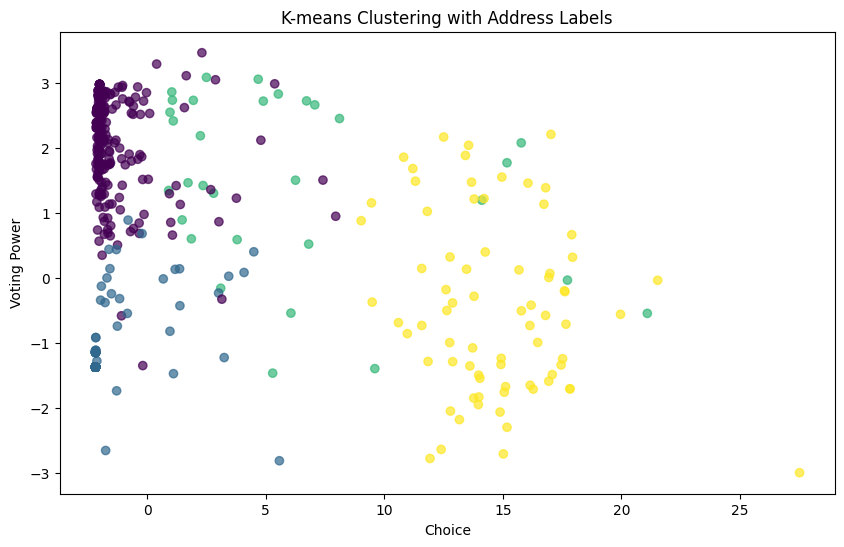

In [70]:
from sklearn.decomposition import PCA

df = pd.read_csv('analytics/clustered_delegates.csv')

pca = PCA(n_components=2)

feature = pca.fit_transform(df.iloc[:, 1:-1])

plt.figure(figsize=(10, 6))
plt.scatter(feature[:, 0], feature[:, 1], c=df['cluster'], cmap='viridis', marker='o', alpha=0.7)

plt.title('K-means Clustering with Address Labels')
plt.xlabel('Choice')
plt.ylabel('Voting Power')
plt.show()